In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from os.path import join
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet
from core.DiT_model_lib import *
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid
from pprint import pprint

saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"


In [4]:
def find_largest_ckpt_step(ckptdir, verbose=True):
    ckpt_files = [f for f in os.listdir(ckptdir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    ckpt_steps = [int(f.split("_")[-1].split(".")[0]) for f in ckpt_files]
    if len(ckpt_steps) == 0:
        if verbose:
            print("No checkpoints found in the directory! check the path: ", ckptdir)
        return None
    else:
        if verbose:
            print(f"Found {len(ckpt_steps)} checkpoints in the directory, largest step is {max(ckpt_steps)}")
        return max(ckpt_steps)


def find_all_ckpt_steps(ckptdir, verbose=True):
    ckpt_files = [f for f in os.listdir(ckptdir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    ckpt_steps = [int(f.split("_")[-1].split(".")[0]) for f in ckpt_files]
    if verbose:
        print(f"Found {len(ckpt_steps)} checkpoints in the directory, largest step is {max(ckpt_steps)}")
    return sorted(ckpt_steps)


# Refactored functions for visualizing gradient maps
from mpl_toolkits.axes_grid1 import ImageGrid
def compute_gradient_map(model, x_shape, sigma_val, output_coords, device, x_probe=None, target="denoiser"):
    """
    Compute gradient map for a specific sigma value and output coordinates.
    
    Args:
        model: The denoiser model
        x_shape: Shape of the input tensor (e.g., (3, 32, 32))
        sigma_val: Sigma value for the denoiser
        output_coords: Tuple of (channel, y, x) coordinates for the output pixel
        device: Device to run computation on
    
    Returns:
        Gradient map tensor
    """
    # Set up the output map (focusing on the specified pixel)
    output_map = torch.zeros(x_shape).to(device)
    if output_coords is None:
        # Default to center pixel if not specified
        c, h, w = x_shape
        output_map[:, h//2, w//2] = 1
    else:
        c, y, x = output_coords
        if c is None:  # If channel is None, set all channels
            output_map[:, y, x] = 1
        else:
            output_map[c, y, x] = 1
    
    # Set up the probe point
    if x_probe is None:
        x_probe = sigma_val * torch.randn(x_shape).to(device)
    else:
        x_probe = x_probe.detach().clone().to(device)
    x_probe.requires_grad_(True)
    
    # Compute the denoiser output
    t_sigma = sigma_val * torch.ones(1, device=device)
    denoised = model(x_probe.view(1, *x_shape), t_sigma)
    if target == "denoiser":
        scalar = (output_map * denoised).sum()
    elif target == "score":
        score = (denoised - x_probe.view(1, *x_shape)) / t_sigma[:, None]
        scalar = (output_map * score[0]).sum()
    else:
        raise ValueError(f"Invalid target: {target}")
    
    # Compute scalar output and get gradient
    scalar.backward()
    # Return the gradient
    return x_probe.grad.detach().cpu()



def visualize_gradient_maps(model, x_shape, sigma_values, output_coords=None, target="denoiser",
                           device='cuda', reduction='abs_mean', figsize=(14, 14)):
    """
    Visualize gradient maps for different sigma values.
    
    Args:
        model: The denoiser model
        x_shape: Shape of the input tensor (e.g., (3, 32, 32))
        sigma_values: List of sigma values to test
        output_coords: Tuple of (channel, y, x) coordinates for the output pixel
                      If None, defaults to center pixel
        device: Device to run computation on
        reduction: How to reduce channel dimension ('abs_mean', 'mean', 'max', or None)
        figsize: Figure size for the plot
    
    Returns:
        List of computed gradient maps
    """
    gradient_maps = []
    
    # Compute gradient maps for each sigma
    for sigma_val in sigma_values:
        print(f"Computing gradient map for sigma = {sigma_val}")
        gradient_map = compute_gradient_map(model, x_shape, sigma_val, output_coords, device, target=target)
        
        # Apply reduction if specified
        if reduction == 'abs_mean':
            gradient_map = gradient_map.abs().mean(0)
        elif reduction == 'mean':
            gradient_map = gradient_map.mean(0)
        elif reduction == 'max':
            gradient_map = gradient_map.abs().max(0)[0]
        # If None, keep all channels
        
        gradient_maps.append(gradient_map)
        # Clear gradients for next iteration
        torch.cuda.empty_cache()
    
    # Create a montage of the gradient maps
    rows = int(len(sigma_values)**0.5)
    cols = (len(sigma_values) + rows - 1) // rows  # Ceiling division
    
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(rows, cols),
                    axes_pad=0.3,
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.1)
    
    # Add each gradient map to the grid
    for i, (gradient_map, sigma_val) in enumerate(zip(gradient_maps, sigma_values)):
        if i < len(grid):  # Ensure we don't go out of bounds
            ax = grid[i]
            
            # Handle multi-channel gradient maps
            if len(gradient_map.shape) == 3 and reduction is None:
                # Just show first channel if no reduction
                im = ax.imshow(gradient_map[0], cmap="viridis")
            else:
                im = ax.imshow(gradient_map, cmap="viridis")
                
            ax.set_title(f"σ = {sigma_val}")
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Add colorbar
    grid.cbar_axes[0].colorbar(im)
    
    # Add title with output coordinates
    if output_coords:
        c, y, x = output_coords
        channel_str = f"channel {c}" if c is not None else "all channels"
        plt.suptitle(f"Gradient Maps of {target} for Different Sigma Values (Output at {channel_str}, y={y}, x={x})")
    else:
        plt.suptitle(f"Gradient Maps of {target} for Different Sigma Values (Output at center pixel)")
    
    plt.tight_layout()
    plt.show()
    
    return fig, gradient_maps


def compute_jacobian(model, x_probe, sigma, device="cuda", target="denoiser", pbar=True):
    x_shape = x_probe.shape
    jacobian = torch.zeros(np.prod(x_shape[:]), np.prod(x_shape[:])).to(device)
    if pbar:
        pbar = trange(np.prod(x_shape[:]))
    else:
        pbar = range(np.prod(x_shape[:]))
    for idx in pbar:
        coords = np.unravel_index(idx, x_shape[:])
        grad = compute_gradient_map(model, x_shape, sigma, coords, device, x_probe=x_probe, target=target)
        jacobian[idx, :] = grad.view(-1)
    return jacobian


# %%
# %% [markdown]
# ### Loading CNN
#%%
def create_unet_model(config):
    unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                decoder_init_attn=config.decoder_init_attn if 'decoder_init_attn' in config else True,
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=config.dropout, 
                img_resolution=config.img_size, 
                label_dim=config.label_dim,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=config.augment_dim, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )
    pytorch_total_grad_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f'total number of trainable parameters in the Score Model: {pytorch_total_grad_params}')
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f'total number of parameters in the Score Model: {pytorch_total_params}')
    return unet

device = "cuda" if torch.cuda.is_available() else "cpu"



In [18]:
# # compute full Jacobian
# x_probe = torch.randn(imgshape).to(device)
# # iterate over all output coordinates
# coords = list(np.ndindex(imgshape[:]))

### MLP

In [57]:
# expname = "FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_saveckpt_fewsample"
expname = "FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_saveckpt_fewsample_longtrain"
imgshape = (3, 32, 32)
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
# config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
img_ndim = 3072
MLP_model = UNetBlockStyleMLP_backbone(ndim=img_ndim, nlayers=args.mlp_layers, nhidden=args.mlp_hidden_dim, time_embed_dim=args.mlp_time_embed_dim,)
MLP_precd = EDMPrecondWrapper(MLP_model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
# ckpt_step = find_largest_ckpt_step(ckptdir)
# %% [markdown]
# #### Gradient Map of MLP denoisers
figdir = join(savedir, "gradient_maps")
jacobdir = join(savedir, "jacobian_store")
os.makedirs(figdir, exist_ok=True)
os.makedirs(jacobdir, exist_ok=True)

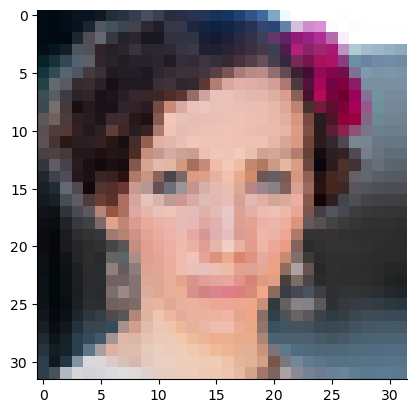

In [102]:
data_Xtsr = torch.load("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset/ffhq-32x32.pt")
ref_x_raw = data_Xtsr[77]
ref_x = (ref_x_raw - 0.5) / 0.5
# ref_x = ref_x.flatten()
plt.imshow(ref_x_raw.permute(1, 2, 0).cpu().numpy())

In [103]:
ckpt_step_list = find_all_ckpt_steps(ckptdir)
ckpt_step = ckpt_step_list[-1]
for ckpt_step in tqdm(ckpt_step_list):
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    MLP_precd.load_state_dict(torch.load(ckpt_path))
    MLP_precd.requires_grad_(False)
    MLP_precd = MLP_precd.to(device).eval();
    MLP_precd_img = lambda x, sigma: MLP_precd(x.view(x.shape[0], -1), sigma).view(-1,*imgshape) # to have the same signature as the other denoisers
    save_dict = {}
    noise_z = torch.randn(imgshape, generator=torch.Generator().manual_seed(0))
    for sigma in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        x_probe = ref_x + sigma * noise_z
        jacobian = compute_jacobian(MLP_precd_img, x_probe, sigma, device, pbar=False)
        save_dict[(sigma, "jacobian")] = jacobian.cpu()
        save_dict[(sigma, "x_probe")] = x_probe
    torch.save(save_dict, join(jacobdir, f"jacobian_ref_img_w_noise_step{ckpt_step:06d}.pth"))

Found 171 checkpoints in the directory, largest step is 249999


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [104]:
ckpt_step_list = find_all_ckpt_steps(ckptdir)
ckpt_step = ckpt_step_list[-1]
for ckpt_step in tqdm(ckpt_step_list):
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    MLP_precd.load_state_dict(torch.load(ckpt_path))
    MLP_precd.requires_grad_(False)
    MLP_precd = MLP_precd.to(device).eval();
    MLP_precd_img = lambda x, sigma: MLP_precd(x.view(x.shape[0], -1), sigma).view(-1,*imgshape) # to have the same signature as the other denoisers
    save_dict = {}
    noise_z = torch.randn(imgshape, generator=torch.Generator().manual_seed(0))
    for sigma in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        x_probe = sigma * noise_z
        jacobian = compute_jacobian(MLP_precd_img, x_probe, sigma, device, pbar=False)
        save_dict[(sigma, "jacobian")] = jacobian.cpu()
        save_dict[(sigma, "x_probe")] = x_probe
    torch.save(save_dict, join(jacobdir, f"jacobian_gauss_noise_step{ckpt_step:06d}.pth"))

Found 171 checkpoints in the directory, largest step is 249999


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

### UNet 

In [ ]:
# loading config 
expname = "FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample_longtrain"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
unet = create_unet_model(config)
CNN_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

figdir = join(savedir, "gradient_maps")
jacobdir = join(savedir, "jacobian_store")
os.makedirs(figdir, exist_ok=True)
os.makedirs(jacobdir, exist_ok=True)

In [ ]:
data_Xtsr = torch.load("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset/ffhq-32x32.pt")
ref_x_raw = data_Xtsr[77]
ref_x = (ref_x_raw - 0.5) / 0.5
# ref_x = ref_x.flatten()
plt.imshow(ref_x_raw.permute(1, 2, 0).cpu().numpy())

In [ ]:
imgshape = (3, 32, 32)
figdir = join(savedir, "gradient_maps")
os.makedirs(figdir, exist_ok=True)
ckpt_step_list = find_all_ckpt_steps(ckptdir)
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    CNN_precd.load_state_dict(torch.load(ckpt_path))
    device = "cuda"
    CNN_precd = CNN_precd.to(device).eval()
    CNN_precd.requires_grad_(False);
    save_dict = {}
    noise_z = torch.randn(imgshape, generator=torch.Generator().manual_seed(0))
    for sigma in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        x_probe = ref_x + sigma * noise_z
        jacobian = compute_jacobian(CNN_precd, x_probe, sigma, device, pbar=False)
        save_dict[(sigma, "jacobian")] = jacobian.cpu()
        save_dict[(sigma, "x_probe")] = x_probe
    torch.save(save_dict, join(jacobdir, f"jacobian_ref_img_w_noise_step{ckpt_step:06d}.pth"))

In [ ]:
ckpt_step_list = find_all_ckpt_steps(ckptdir)
ckpt_step = ckpt_step_list[-1]
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    CNN_precd.load_state_dict(torch.load(ckpt_path))
    device = "cuda"
    CNN_precd = CNN_precd.to(device).eval()
    CNN_precd.requires_grad_(False);
    save_dict = {}
    noise_z = torch.randn(imgshape, generator=torch.Generator().manual_seed(0))
    for sigma in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        x_probe = sigma * noise_z
        jacobian = compute_jacobian(CNN_precd, x_probe, sigma, device, pbar=False)
        save_dict[(sigma, "jacobian")] = jacobian.cpu()
        save_dict[(sigma, "x_probe")] = x_probe
    torch.save(save_dict, join(jacobdir, f"jacobian_gauss_noise_step{ckpt_step:06d}.pth"))

In [ ]:
# %% [markdown]
# #### Demo of gradient map
# %% [markdown]
# #### Gradient Map of CNN Unet denoisers
imgshape = (3, 32, 32)
figdir = join(savedir, "gradient_maps")
os.makedirs(figdir, exist_ok=True)
ckpt_step_list = find_all_ckpt_steps(ckptdir)
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    CNN_precd.load_state_dict(torch.load(ckpt_path))
    device = "cuda"
    CNN_precd = CNN_precd.to(device).eval()
    CNN_precd.requires_grad_(False);

### DiT

In [ ]:
device = "cuda"
imgshape = (3, 32, 32)

# loading config 
expname = "FFHQ32_DiT_P2_384D_6H_6L_EDM_saveckpt_fewsample_longtrain"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
DiT_model = DiT(**config)
DiT_precd = EDMDiTPrecondWrapper(DiT_model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

figdir = join(savedir, "gradient_maps")
jacobdir = join(savedir, "jacobian_store")
os.makedirs(figdir, exist_ok=True)
os.makedirs(jacobdir, exist_ok=True)
# Find the largest checkpoint step in the directory
# ckpt_step = find_largest_ckpt_step(ckptdir)
# device = "cuda"
# ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
# DiT_precd.load_state_dict(torch.load(ckpt_path))
# DiT_precd = DiT_precd.to(device).eval()
# DiT_precd.requires_grad_(False);

In [ ]:
data_Xtsr = torch.load("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset/ffhq-32x32.pt")
ref_x_raw = data_Xtsr[77]
ref_x = (ref_x_raw - 0.5) / 0.5
# ref_x = ref_x.flatten()
plt.imshow(ref_x_raw.permute(1, 2, 0).cpu().numpy())

In [ ]:
os.makedirs(figdir, exist_ok=True)
ckpt_step_list = find_all_ckpt_steps(ckptdir)
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    DiT_precd.load_state_dict(torch.load(ckpt_path))
    DiT_precd = DiT_precd.to(device).eval()
    DiT_precd.requires_grad_(False);
    save_dict = {}
    noise_z = torch.randn(imgshape, generator=torch.Generator().manual_seed(0))
    for sigma in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        x_probe = ref_x + sigma * noise_z
        jacobian = compute_jacobian(DiT_precd, x_probe, sigma, device, pbar=False)
        save_dict[(sigma, "jacobian")] = jacobian.cpu()
        save_dict[(sigma, "x_probe")] = x_probe
    torch.save(save_dict, join(jacobdir, f"jacobian_ref_img_w_noise_step{ckpt_step:06d}.pth"))
    
    
ckpt_step_list = find_all_ckpt_steps(ckptdir)
ckpt_step = ckpt_step_list[-1]
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    DiT_precd.load_state_dict(torch.load(ckpt_path))
    DiT_precd = DiT_precd.to(device).eval()
    DiT_precd.requires_grad_(False);
    save_dict = {}
    noise_z = torch.randn(imgshape, generator=torch.Generator().manual_seed(0))
    for sigma in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        x_probe = sigma * noise_z
        jacobian = compute_jacobian(DiT_precd, x_probe, sigma, device, pbar=False)
        save_dict[(sigma, "jacobian")] = jacobian.cpu()
        save_dict[(sigma, "x_probe")] = x_probe
    torch.save(save_dict, join(jacobdir, f"jacobian_gauss_noise_step{ckpt_step:06d}.pth"))

In [ ]:
ckpt_step_list = find_all_ckpt_steps(ckptdir)
ckpt_step = ckpt_step_list[-1]
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    DiT_precd.load_state_dict(torch.load(ckpt_path))
    DiT_precd = DiT_precd.to(device).eval()
    DiT_precd.requires_grad_(False);
    save_dict = {}
    noise_z = torch.randn(imgshape, generator=torch.Generator().manual_seed(0))
    for sigma in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        x_probe = sigma * noise_z
        jacobian = compute_jacobian(DiT_precd, x_probe, sigma, device, pbar=False)
        save_dict[(sigma, "jacobian")] = jacobian.cpu()
        save_dict[(sigma, "x_probe")] = x_probe
    torch.save(save_dict, join(jacobdir, f"jacobian_gauss_noise_step{ckpt_step:06d}.pth"))

In [ ]:
figdir = join(savedir, "gradient_maps")
os.makedirs(figdir, exist_ok=True)
ckpt_step_list = find_all_ckpt_steps(ckptdir)
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    DiT_precd.load_state_dict(torch.load(ckpt_path))
    DiT_precd = DiT_precd.to(device).eval()
    DiT_precd.requires_grad_(False);
    
    sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
    fig, grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, output_coords=(None, 15, 15), target="denoiser");
    saveallforms(figdir, f"gradient_map_DiT_denoiser_ckpt_{ckpt_step:06d}_pos_15_15", fig)
    fig, grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, output_coords=(None, 15, 10), target="denoiser");
    saveallforms(figdir, f"gradient_map_DiT_denoiser_ckpt_{ckpt_step:06d}_pos_15_10", fig)
    fig, grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, output_coords=(None, 15, 20), target="denoiser");
    saveallforms(figdir, f"gradient_map_DiT_denoiser_ckpt_{ckpt_step:06d}_pos_15_20", fig)
    fig, grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, output_coords=(None, 5, 5), target="denoiser");
    saveallforms(figdir, f"gradient_map_DiT_denoiser_ckpt_{ckpt_step:06d}_pos_5_5", fig)
    fig, grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, output_coords=(None, 28, 28), target="denoiser");
    saveallforms(figdir, f"gradient_map_DiT_denoiser_ckpt_{ckpt_step:06d}_pos_28_28", fig)
    plt.close("all")


In [54]:
from tqdm.auto import trange
sigma = 0.5
ckpt_step_list = find_all_ckpt_steps(ckptdir)
ckpt_step = ckpt_step_list[-1]
ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
MLP_precd.load_state_dict(torch.load(ckpt_path))
MLP_precd.requires_grad_(False)
MLP_precd = MLP_precd.to(device).eval();
MLP_precd_img = lambda x, sigma: MLP_precd(x.view(x.shape[0], -1), sigma).view(-1,*imgshape) # to have the same signature as the other denoisers
x_probe = sigma * torch.randn(imgshape)
jacobian = compute_jacobian(MLP_precd_img, x_probe, sigma, device)
# jacobian = torch.zeros(np.prod(imgshape[:]), np.prod(imgshape[:])).to(device)
# for idx in trange(np.prod(imgshape[:])):
#     coords = np.unravel_index(idx, imgshape[:])
#     grad = compute_gradient_map(MLP_precd_img, imgshape, sigma, coords, device, x_probe=x_probe, target="denoiser")
#     jacobian[idx, :] = grad.view(-1)

Found 171 checkpoints in the directory, largest step is 249999


  0%|          | 0/3072 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Projective field')

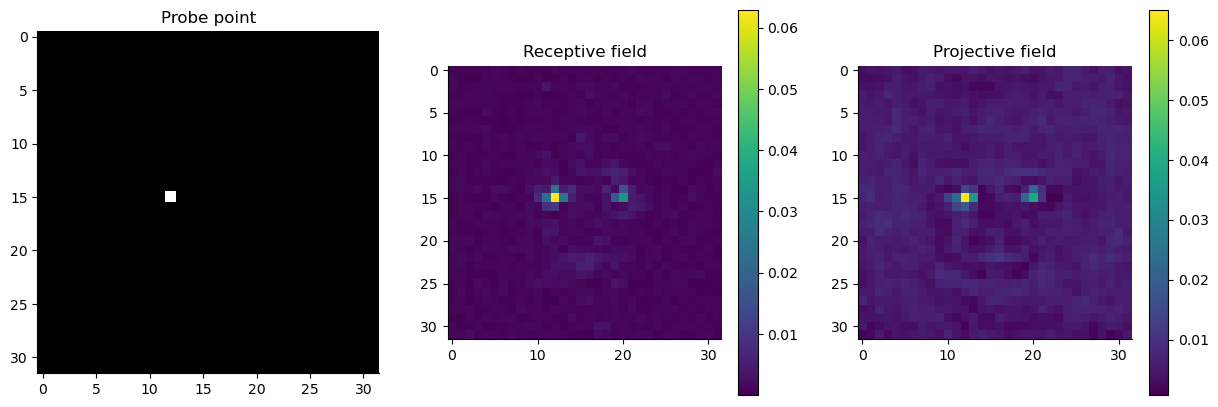

In [55]:
idx = np.ravel_multi_index((1, 15, 12), imgshape[:])
plt.figure(figsize=(15, 5))
# highlight the pixel
plt.subplot(131)
probe_mask = np.zeros(np.prod(imgshape[:]))
probe_mask[idx] = 1
plt.imshow(probe_mask.reshape(imgshape[:]).mean(0), cmap="gray")
plt.title("Probe point")
plt.subplot(132)
plt.imshow(jacobian[idx, :].reshape(imgshape[:]).abs().mean(0).cpu().numpy())
plt.colorbar()
plt.title("Receptive field")
plt.subplot(133)
plt.imshow(jacobian[:, idx].reshape(imgshape[:]).abs().mean(0).cpu().numpy())
plt.colorbar()
plt.title("Projective field")

Top 5 eigenvalues by magnitude:
tensor([1.0485+0.0000j, 1.0168+0.0000j, 1.0110+0.0000j, 1.0005+0.0064j,
        1.0005-0.0064j], device='cuda:0')


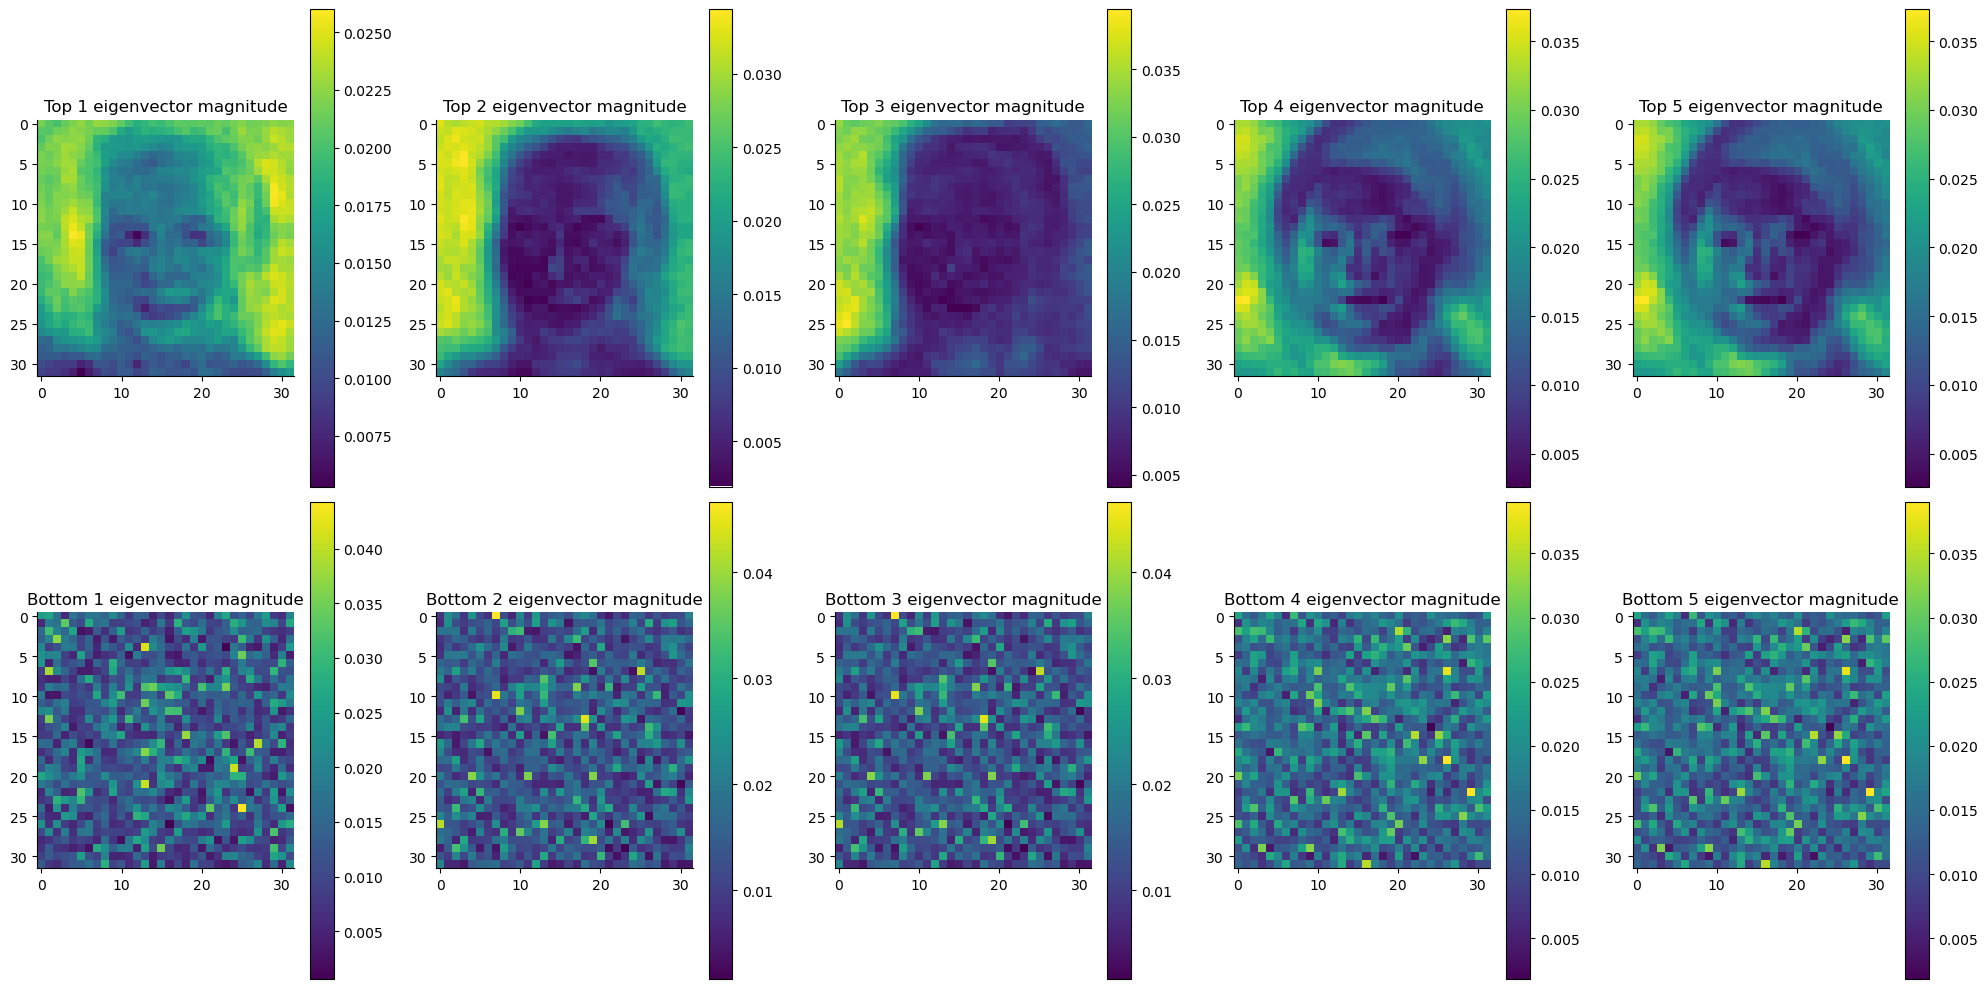

In [56]:
# Compute eigenvalues and eigenvectors of the Jacobian matrix
eigenvalues, eigenvectors = torch.linalg.eig(jacobian)
# Sort eigenvalues by magnitude (descending)
sorted_indices = torch.argsort(eigenvalues.abs(), descending=True)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
# Display top eigenvalues
print("Top 5 eigenvalues by magnitude:")
print(sorted_eigenvalues[:5])
# Visualize the top 5 and bottom 5 eigenvectors
plt.figure(figsize=(20, 10))
# Plot top 5 eigenvectors
for i in range(5):
    plt.subplot(2, 5, i+1)
    top_eigenvector = sorted_eigenvectors[:, i].reshape(imgshape[:])
    plt.imshow(top_eigenvector.abs().mean(0).cpu().numpy())
    plt.colorbar()
    plt.title(f"Top {i+1} eigenvector magnitude")

# Plot bottom 5 eigenvectors
for i in range(5):
    plt.subplot(2, 5, i+6)
    bottom_idx = len(sorted_eigenvalues) - i - 1
    bottom_eigenvector = sorted_eigenvectors[:, bottom_idx].reshape(imgshape[:])
    plt.imshow(bottom_eigenvector.abs().mean(0).cpu().numpy())
    plt.colorbar()
    plt.title(f"Bottom {i+1} eigenvector magnitude")

plt.tight_layout()

In [16]:
grad.shape

torch.Size([3, 32, 32])

Found 171 checkpoints in the directory, largest step is 249999
Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_557924/3854339296.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


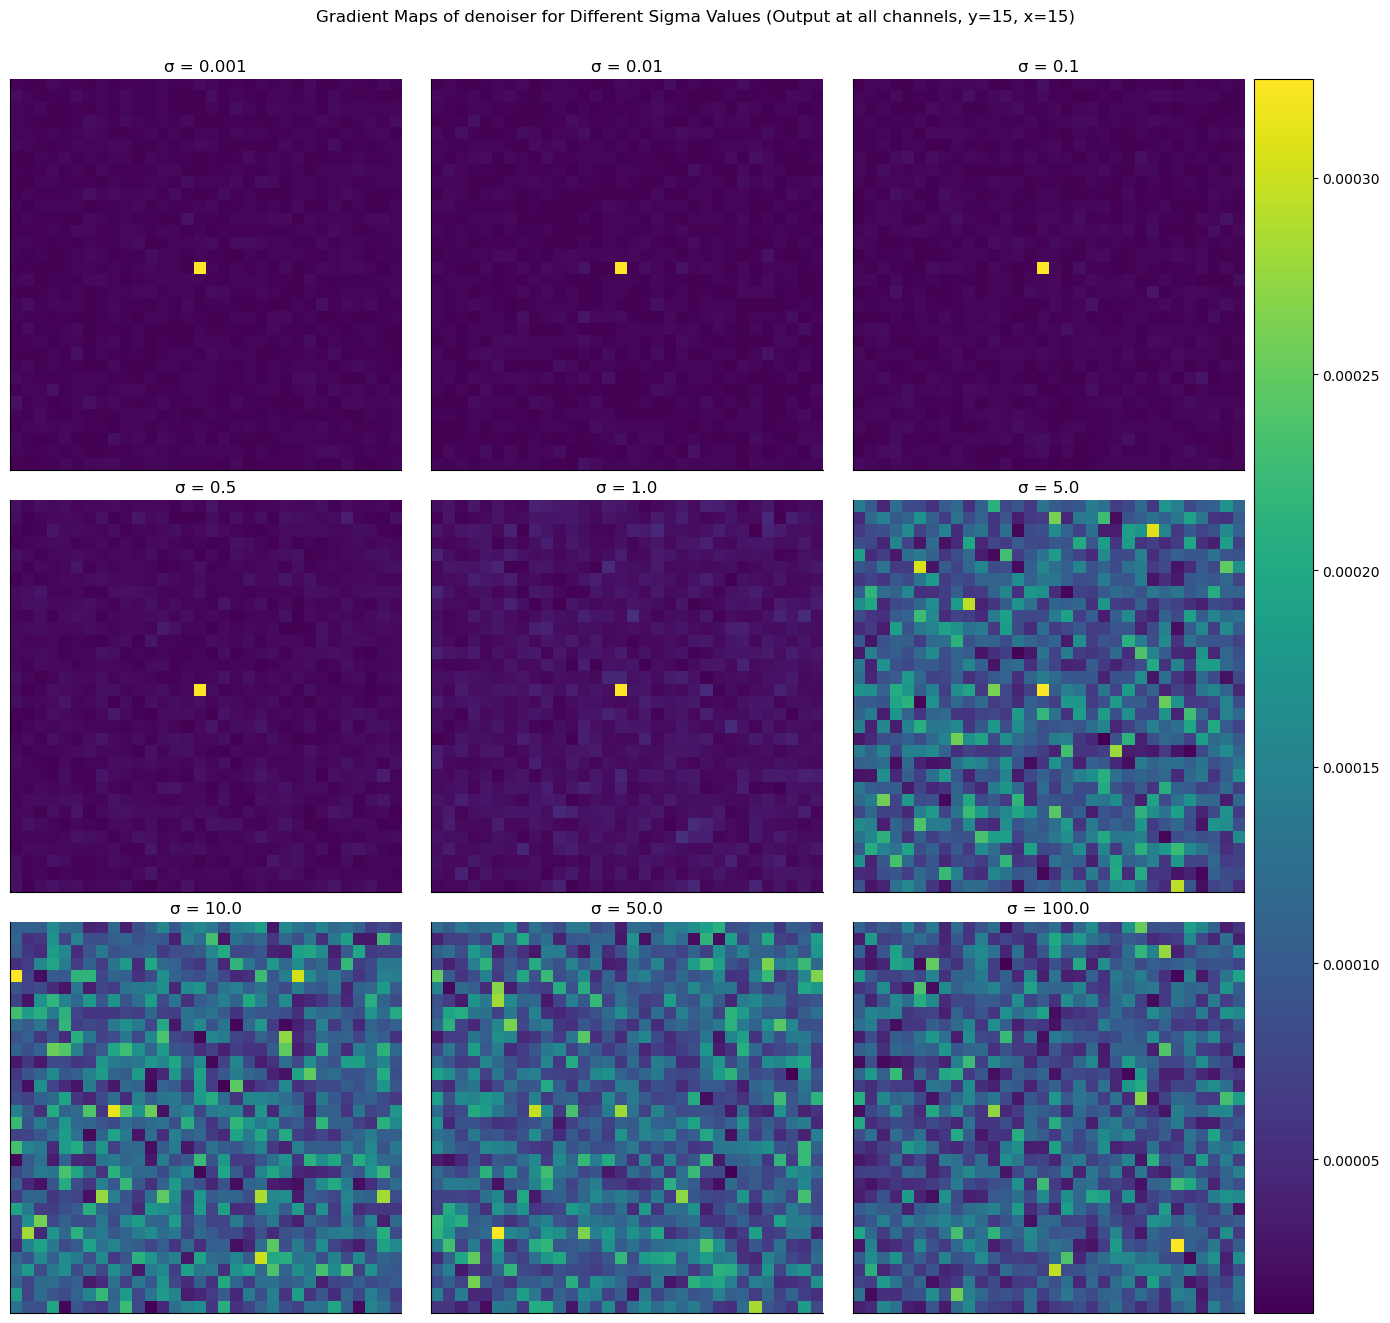

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


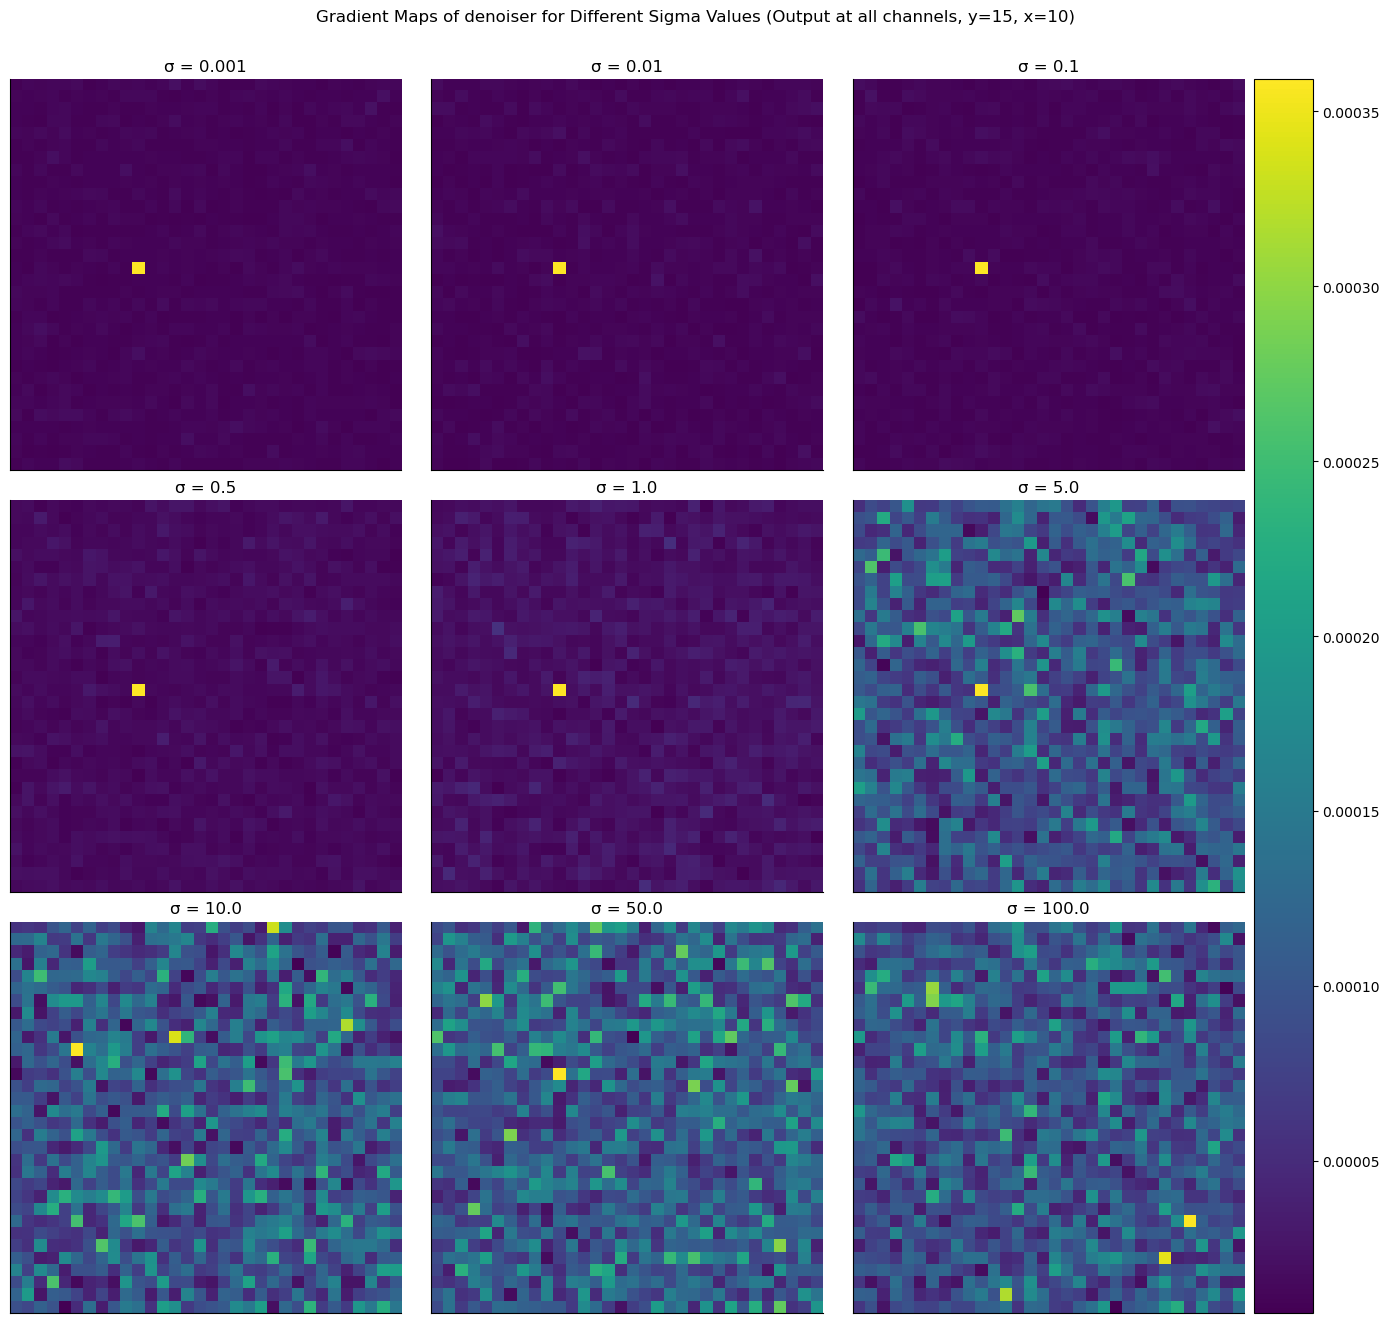

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


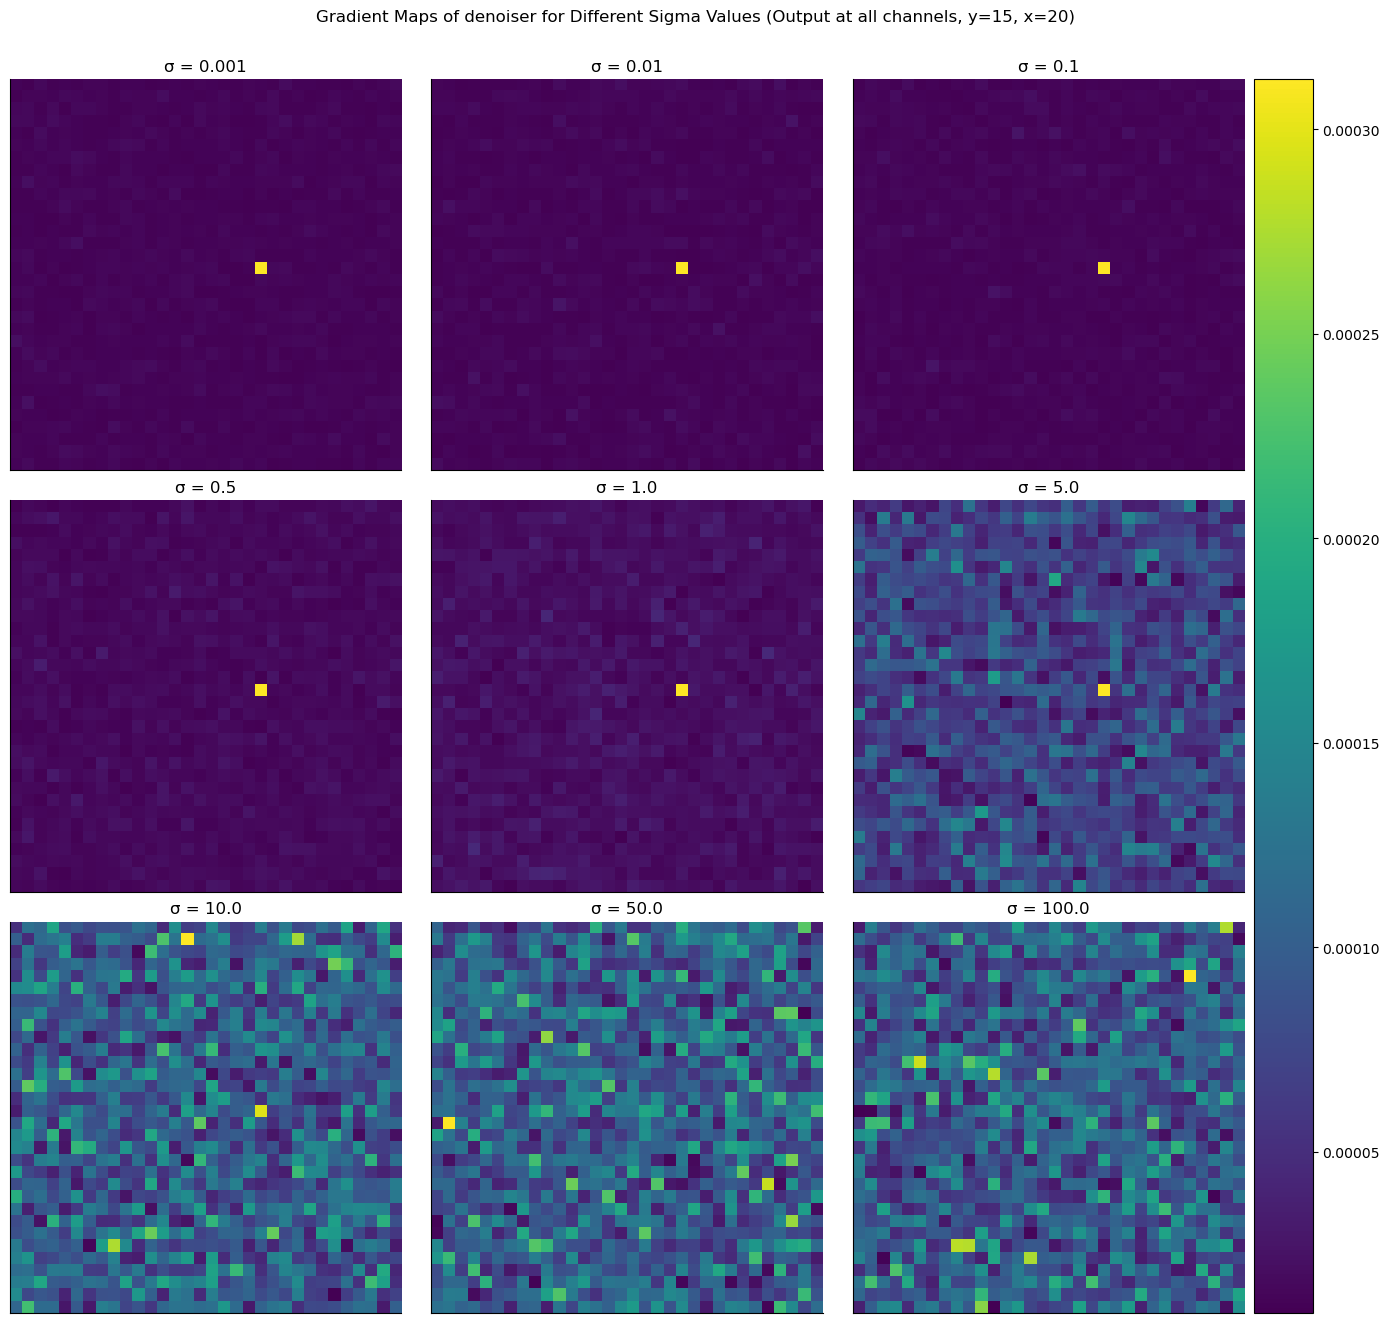

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


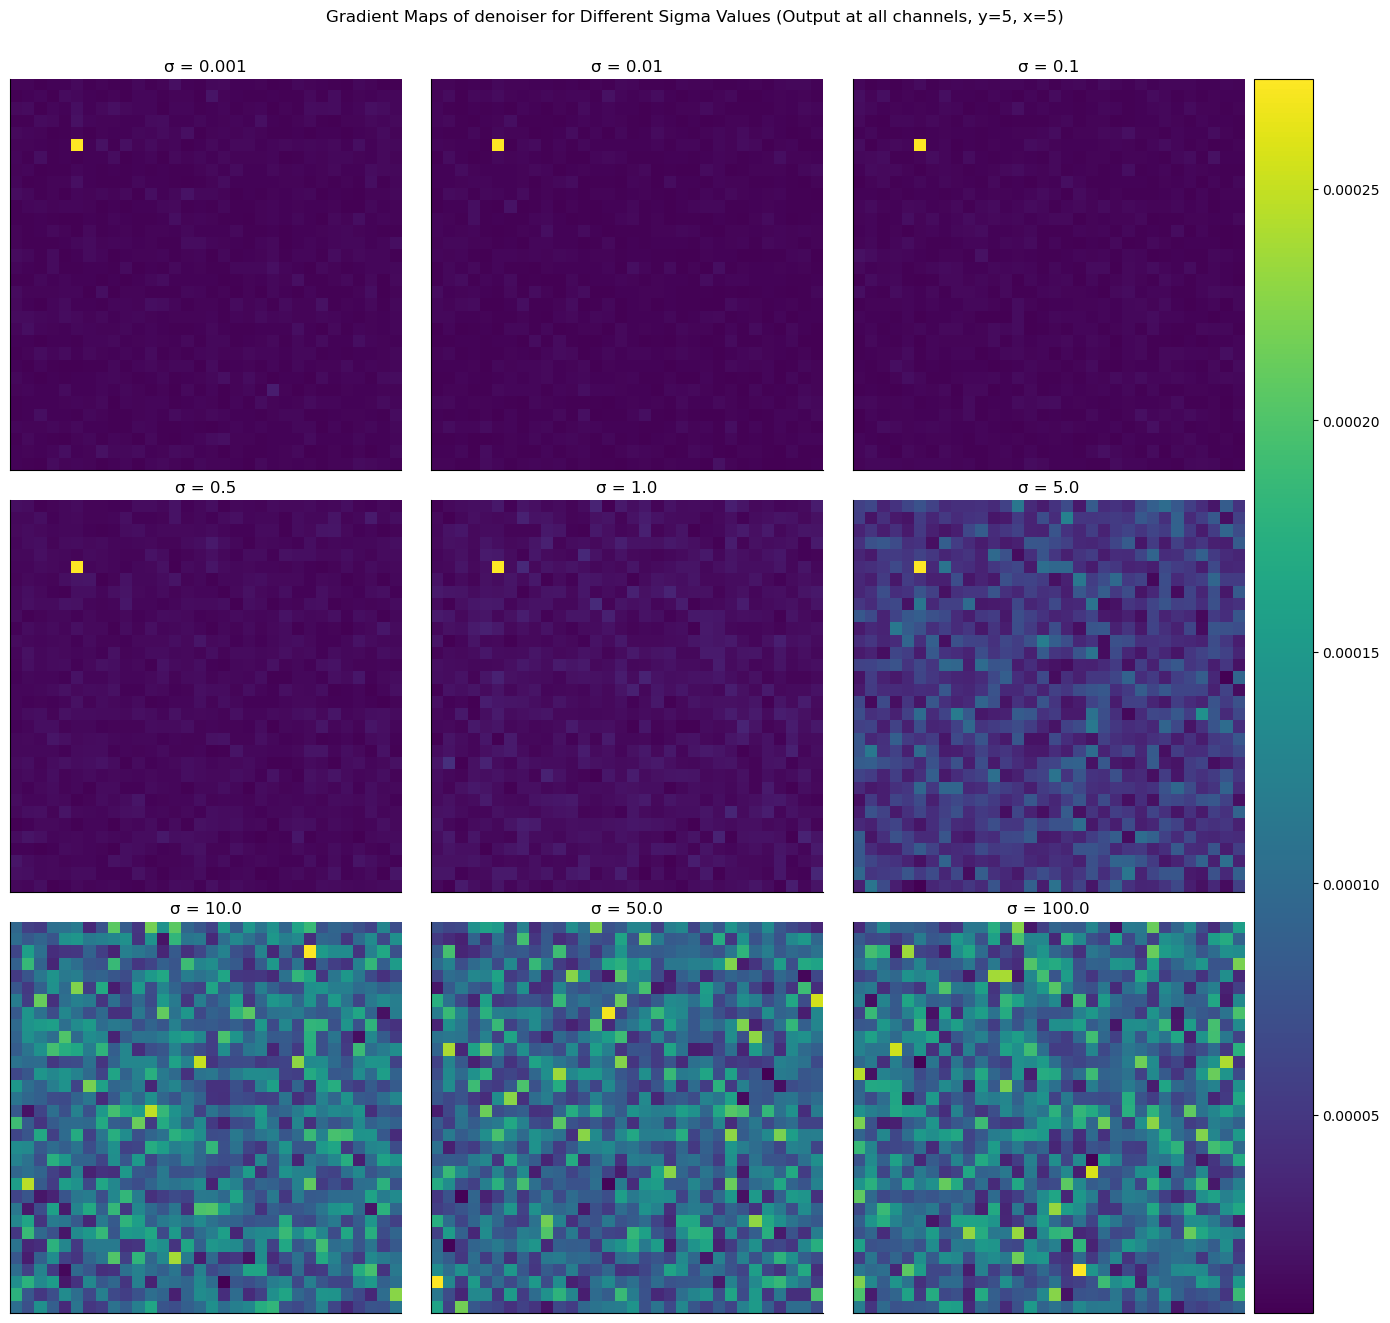

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


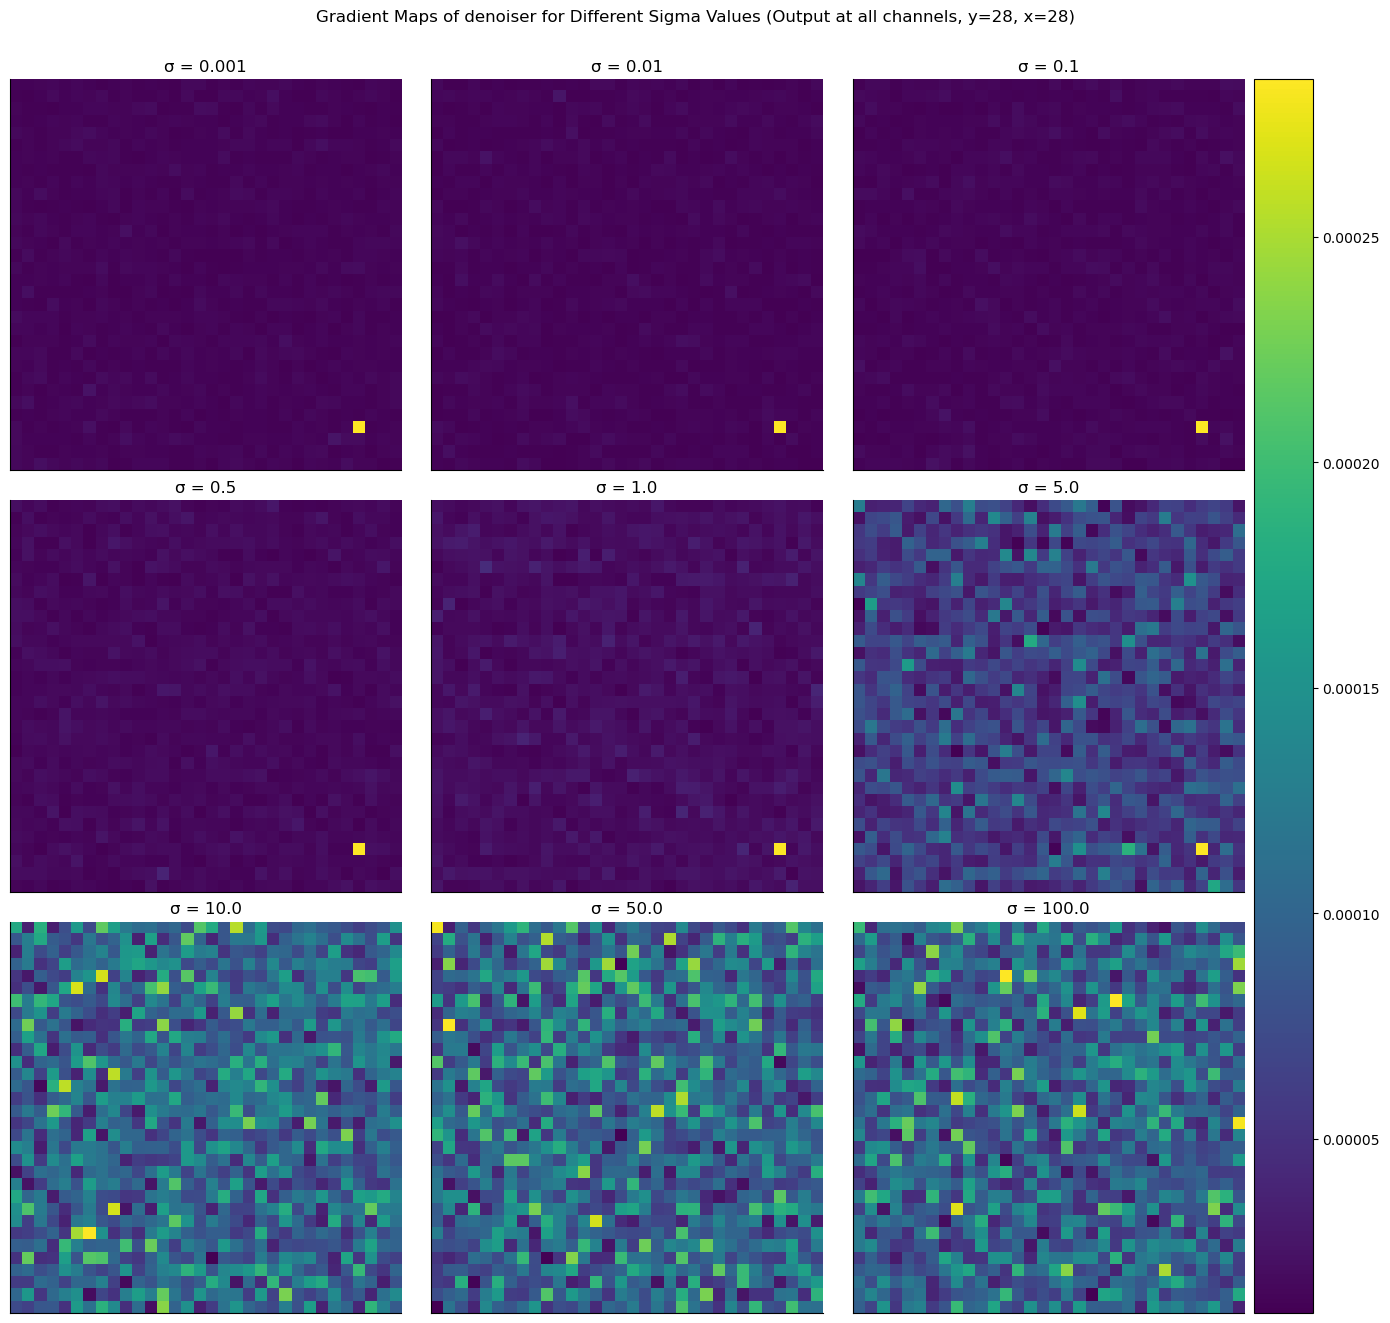

In [8]:
ckpt_step_list = find_all_ckpt_steps(ckptdir)
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    MLP_precd.load_state_dict(torch.load(ckpt_path))
    MLP_precd.requires_grad_(False)
    MLP_precd = MLP_precd.to(device).eval();
    MLP_precd_img = lambda x, sigma: MLP_precd(x.view(x.shape[0], -1), sigma).view(-1,*imgshape) # to have the same signature as the other denoisers
    compute_gradient_map(MLP_precd_img, imgshape, 0.001, (None, 15, 15), device, target="denoiser")
    sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
    fig, grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, output_coords=(None, 15, 15), target="denoiser");
    saveallforms(figdir, f"gradient_map_mlp_denoiser_ckpt_{ckpt_step:06d}_pos_15_15", fig)
    fig, grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, output_coords=(None, 15, 10), target="denoiser");
    saveallforms(figdir, f"gradient_map_mlp_denoiser_ckpt_{ckpt_step:06d}_pos_15_10", fig)
    fig, grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, output_coords=(None, 15, 20), target="denoiser");
    saveallforms(figdir, f"gradient_map_mlp_denoiser_ckpt_{ckpt_step:06d}_pos_15_20", fig)
    fig, grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, output_coords=(None, 5, 5), target="denoiser");
    saveallforms(figdir, f"gradient_map_mlp_denoiser_ckpt_{ckpt_step:06d}_pos_5_5", fig)
    fig, grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, output_coords=(None, 28, 28), target="denoiser");
    saveallforms(figdir, f"gradient_map_mlp_denoiser_ckpt_{ckpt_step:06d}_pos_28_28", fig)
    plt.close("all")
    break